In [1]:
%pip install quandl

Note: you may need to restart the kernel to use updated packages.


In [68]:
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline
directory = './saved_data'
quandl.ApiConfig.api_key = '6c6zAxUrHN7zKv4cG__z'
if not os.path.exists(directory):
    os.makedirs(directory)
    


#### So first, before going into the details, we go to the ticker we conduct a simple time series analysis on ticker price

In [69]:
price = quandl.get('EOD/'+ticker, start_date='2014-01-01', end_date='2019-10-18')
price['date']=price.index
price=price.loc[:,['Adj_Close','Adj_Volume','date']]

before we go to machine learning, lets do a simple time series analysis

In [132]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
from datetime import timedelta
import plotly
import matplotlib.pyplot as plt
%matplotlib inline
from plotly import tools
import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
import chart_studio.plotly as py
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

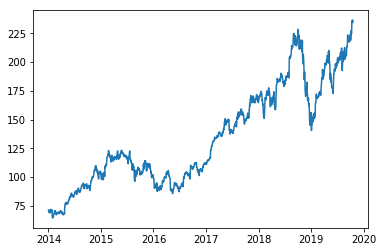

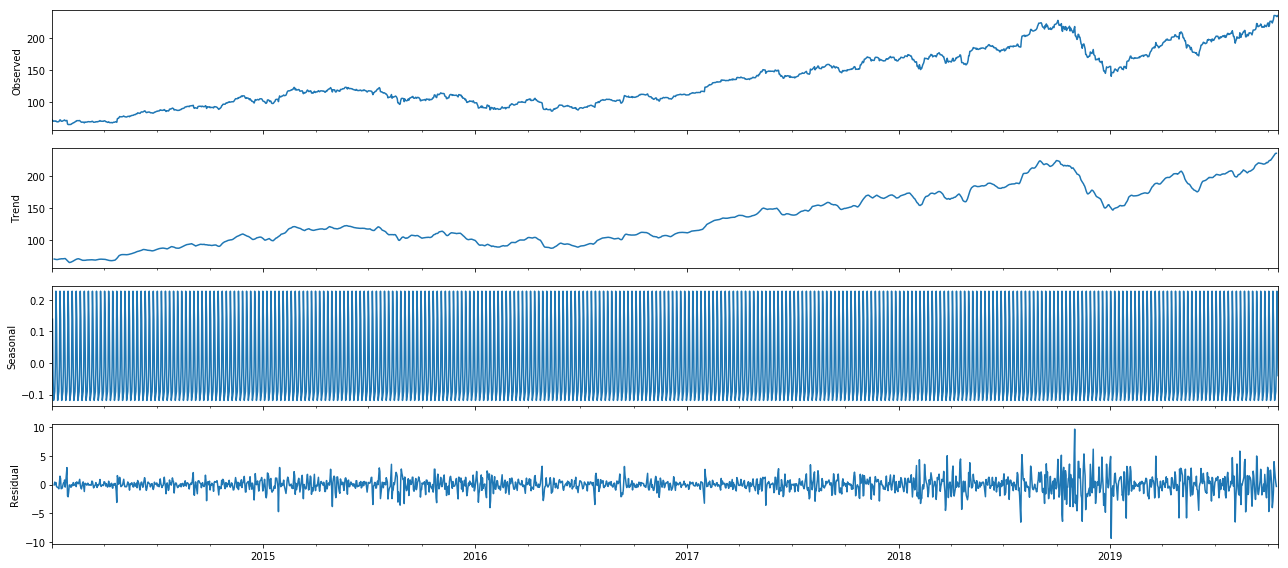

In [115]:
close_price=price.loc[:,['Adj_Close']]
idx = pd.date_range(min(close_price.index), max(close_price.index))
close_price = close_price.reindex(idx)
close_price = interpolate_dataset(close_price)

plt.plot(close_price)
plt.show()
decomposition = sm.tsa.seasonal_decompose(close_price, model='additive')
plt.rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

#### Here I use AWS to conduct the multi-cpu grid search for best time series

In [182]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
from datetime import timedelta
import plotly
import matplotlib.pyplot as plt
import os
import quandl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

quandl.ApiConfig.api_key = '6c6zAxUrHN7zKv4cG__z'

from plotly import tools
import seaborn as sns

import plotly.graph_objs as go
import plotly.figure_factory as ff
import chart_studio.plotly as py
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from tqdm import tqdm_notebook
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from tqdm import tqdm


def interpolate_dataset(dataset):
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                    if str(dataset.iloc[ii+1,jj])=='nan':
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                    else:
                        dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
                except:
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
    return dataset





def myfun(x):
    return x**2
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train.values]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = [delayed(score_model)(data, n_test, cfg) for cfg in cfg_list]
        scores = executor(tasks)
        print(scores)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models


if __name__ == '__main__':
    ticker='AAPL'
    price = quandl.get('EOD/'+ticker, start_date='2014-01-01', end_date='2019-10-18')
    price['date']=price.index
    price=price.loc[:,['Adj_Close','Adj_Volume','date']]
    close_price=price.loc[:,['Adj_Close']]
    idx = pd.date_range(min(close_price.index), max(close_price.index))
    close_price = close_price.reindex(idx)
    close_price = interpolate_dataset(close_price)

    # data split
    n_test = 15
    # model configs
    print('start grid Search')
    cfg_list = sarima_configs(seasonal=[12])
    # grid search
    scores = grid_search(close_price, cfg_list, n_test)
    print('done')
    # list top 3 configs
    for cfg, error in scores[:3]:
        print(cfg, error)
    print(scores[:10],  file=open('./ranking.txt', 'w'))

Then the Super computer gives the ranking of different parameters. Finally, cfg = [(0, 0, 2), (1, 0, 2, 12), 'n'] is the best result. Here then I created forcasting modeling for the stock price i selected. 

C:\Users\richard\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.9212      0.034     55.777      0.000       1.854       1.989
ma.L2          1.7965      0.045     39.949      0.000       1.708       1.885
ar.S.L12       1.0096      0.001    835.642      0.000       1.007       1.012
ma.S.L12      -1.0977      0.103    -10.704      0.000      -1.299      -0.897
ma.S.L24       4.6999      0.361     13.022      0.000       3.993       5.407
sigma2         0.1496      0.024      6.198      0.000       0.102       0.197


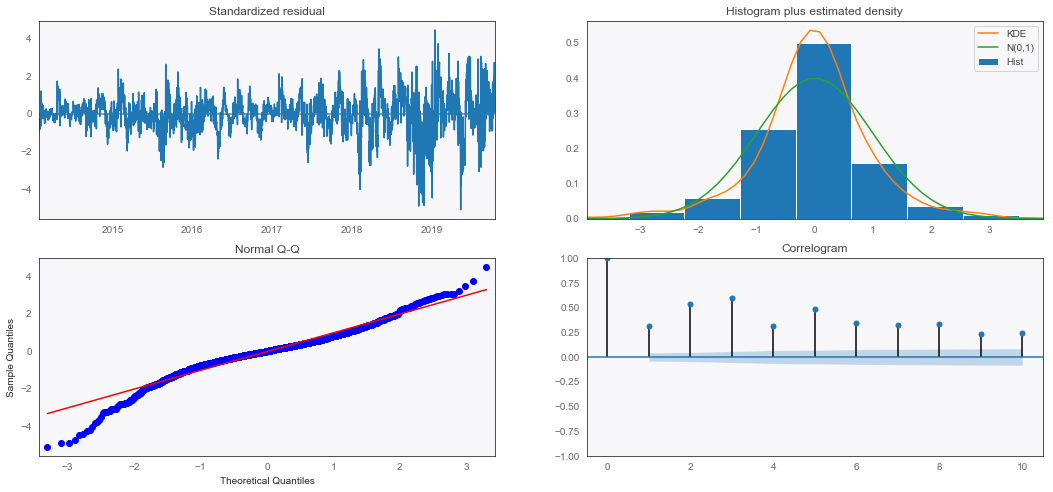

In [160]:
cfg = [(0, 0, 2), (1, 0, 2, 12), 'n']
order, sorder, trend = cfg

mod = SARIMAX(close_price, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])
results.plot_diagnostics(figsize=(18, 8))
plt.show()

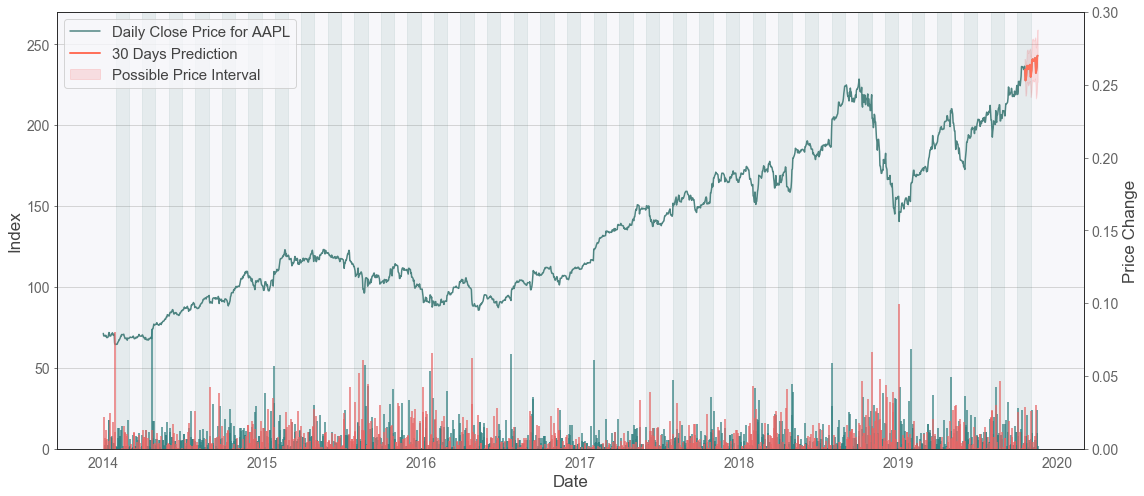

<Figure size 432x288 with 0 Axes>

In [163]:
sns.set_style("white", {'font_scale':0.9,
                           'font.scale':0.9,
                           'xtick.color':'#656565',
                           'ytick.color':'#656565',
                           'text.color': '#424242',
                           'legend.frameon': True})


forecast = results.forecast(steps=30)
start_date = min(close_price.index)
start_predict_date = max(close_price.index)
end_date = max(close_price.index) + timedelta(days=30)
pred=results.get_prediction(start=start_predict_date,end=end_date,dynamic=False)
pred_ci = pred.conf_int()
forecast2=pd.DataFrame(forecast)
forecast2.columns=list(close_price)
df1=pd.concat([close_price,forecast2],axis=0)



# get shaded date
dates=[]
for i in range(len(df1)):
    if df1.index[i].day==1:
        dates.append(df1.index[i])




#percentage change
price_change=df1.iloc[:,0].values
price_change=(price_change[1:]-price_change[:-1])/price_change[:-1]
price_change=np.insert(price_change, 0, 0)
positive_change=[]
negative_change=[]
for i in price_change:
    if i>=0:
        positive_change.append(i)
        negative_change.append(np.nan)
    else:
        positive_change.append(np.nan)
        negative_change.append(-i)     
#370 200

plt.rcParams['axes.facecolor']='#F7F7FA'
fig, ax1 = plt.subplots(figsize=(16,7))
ax1.set_ylim(0,270)
ax1.tick_params(labelsize=13,color='#545454')

line_a=ax1.plot(df1,COLOR='#4E8481',lw=1.5,label='Daily Close Price for {}'.format(ticker))
line_b=ax1.plot(forecast,color='#FF715B',lw=2,label='30 Days Prediction')


ax1.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.1,label='Possible Price Interval')
ax1.yaxis.grid()
for i in range(int(len(dates)/2)):
    ax1.axvspan(dates[2*i], dates[2*i+1], alpha=0.1, color='#4e8481')
    
ax1.set_xlabel('Date',fontsize=17, color='#434343')
ax1.set_ylabel('Index',fontsize=17, color='#434343')  
ax1.tick_params(axis='y', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Price Change',fontsize=17, color='#434343')  # we already handled the x-label with ax1
ax2.vlines(df1.index, ymin=0, ymax=positive_change,color=(0.2, 0.5, 0.5, 0.9))
ax2.vlines(df1.index, ymin=0, ymax=negative_change,color=(0.9, 0.4, 0.4, 0.9))
ax2.set_ylim((0,0.3))
ax2.tick_params(axis='y', labelsize=14)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='upper left',fontsize=15)
plt.show()
plt.savefig('figure1.eps', format='eps')

#### time-series model did not give great result at this case, but it gives very good result to commodities indexes where there are higher seasonality.
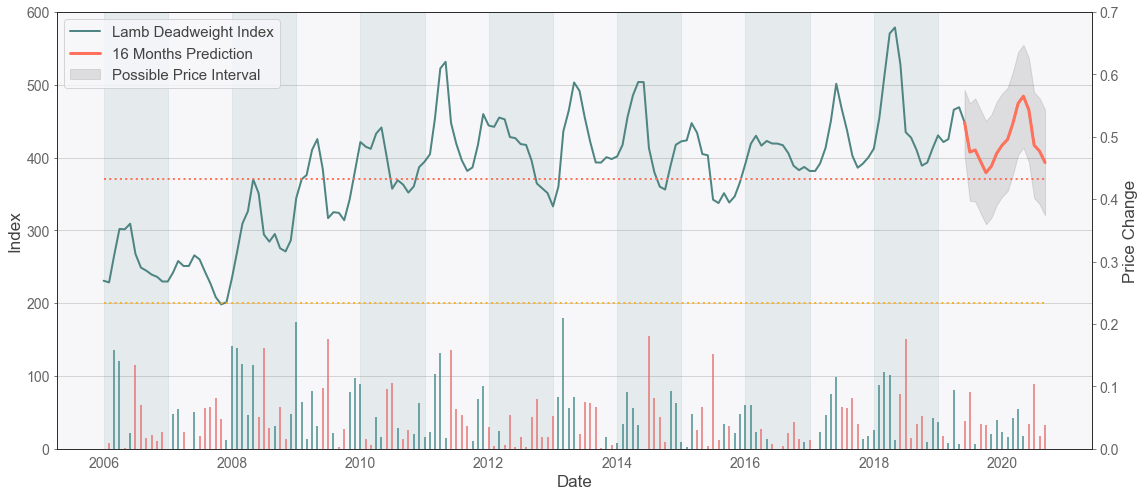

# facebook data (check data quality by EDA)

In [70]:
data = quandl.get_table('SMA/FBD', brand_ticker = 'AAPL', paginate=True)
colnames = list(data)
for i in ['page_id','sector', 'geography']:
    colnames.remove(i)
data2 = data.loc[:,colnames]
data2 = data2.groupby('date').mean()
data2['brand_ticker'] = 'AAPL'

C:\Users\richard\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\richard\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


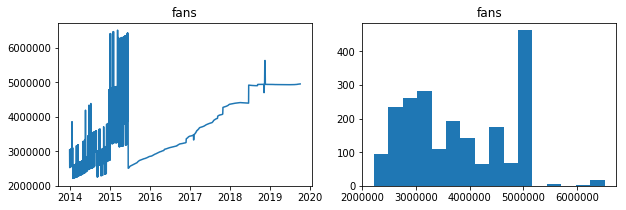

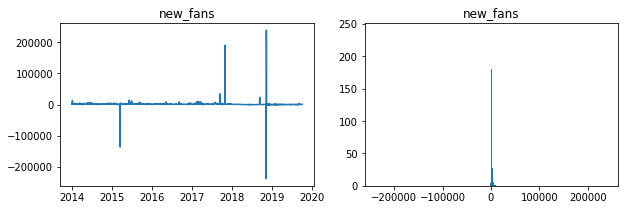

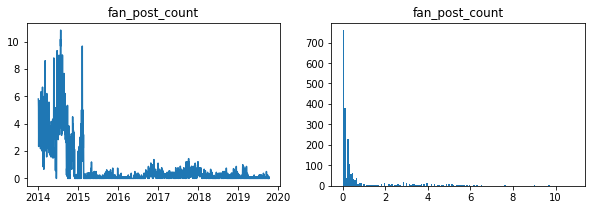

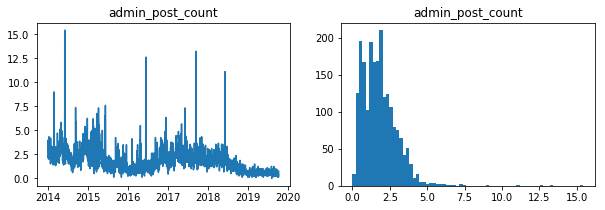

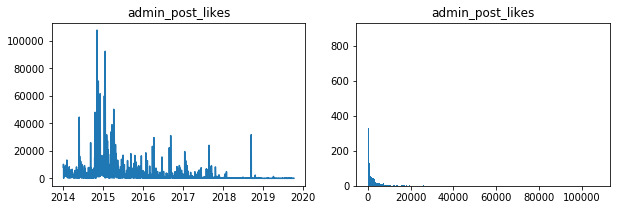

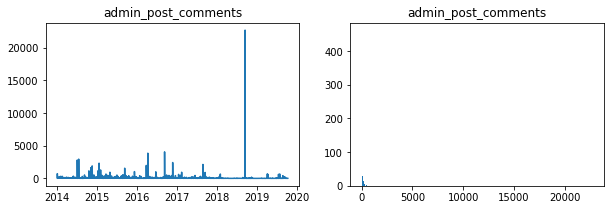

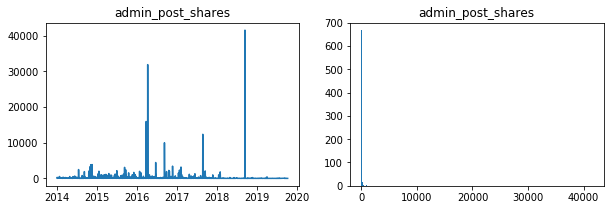

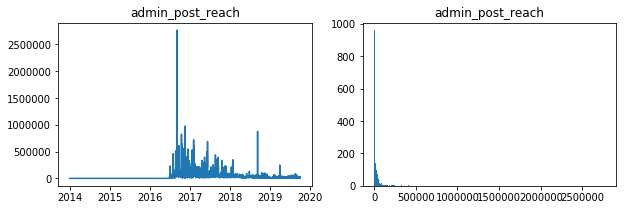

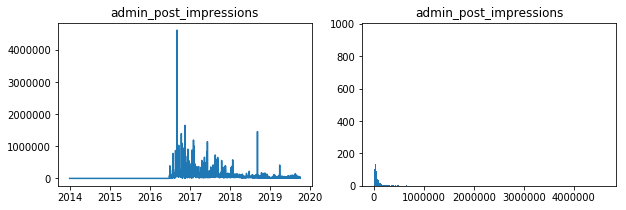

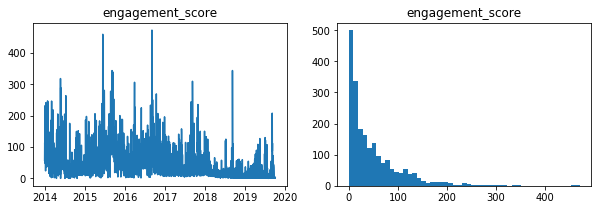

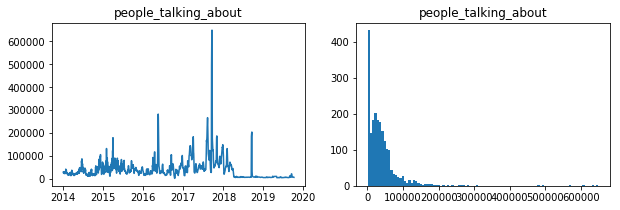

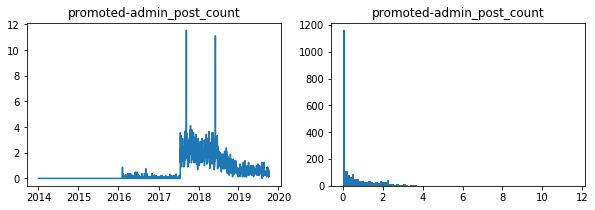

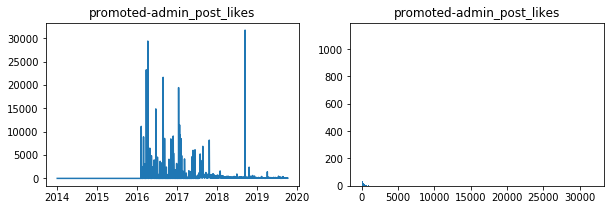

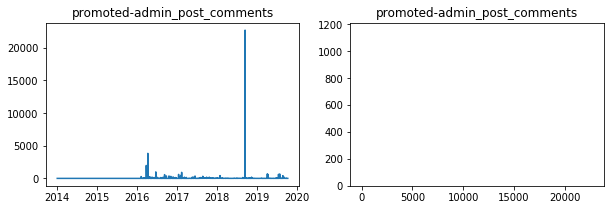

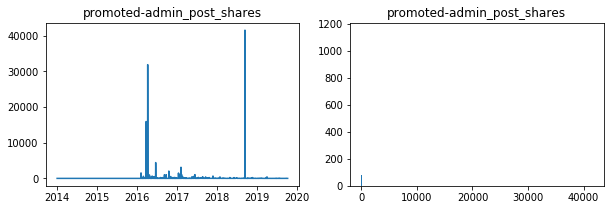

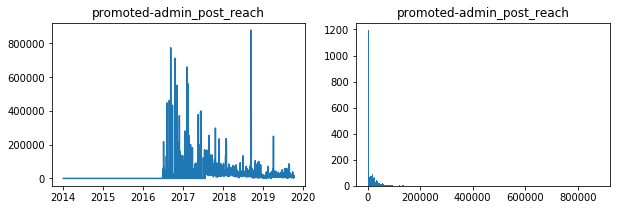

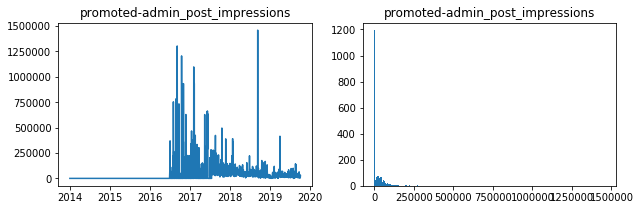

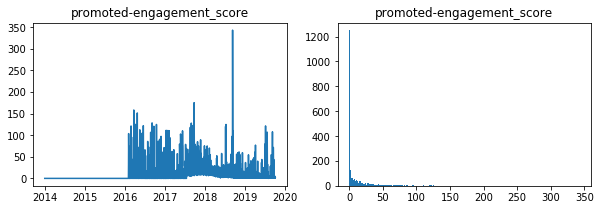

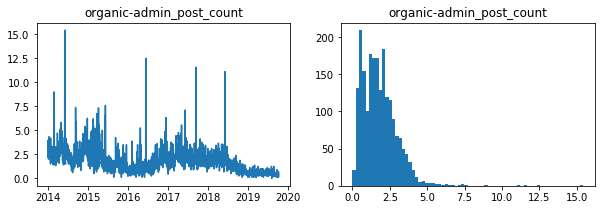

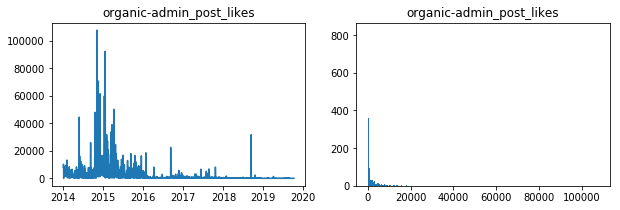

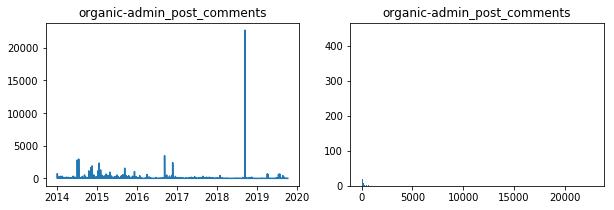

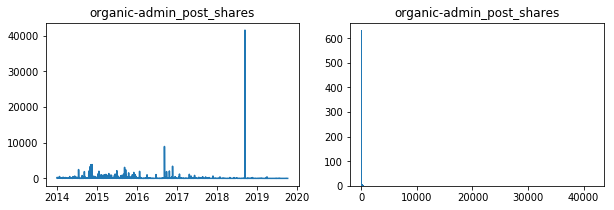

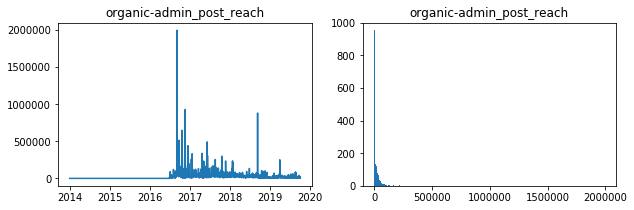

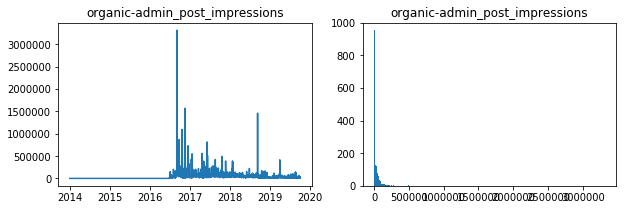

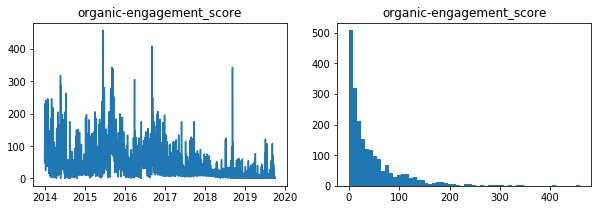

In [5]:
for i in list(data2)[:-1]:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.plot(data2.loc[:,i])
    plt.title(i)
    plt.subplot(1,2,2)
    plt.hist(data2.loc[:,i], bins='auto')
    plt.title(i)    
plt.show()

So we keep ['fan_post_count','organic-admin_post_count','organic-admin_post_likes','organic-admin_post_comments','organic-admin_post_shares','organic-engagement_score']

And we can use use PCA to further reduce the dimension while keep the information.

## write the code above into function

In [71]:
ticker='AAPL'
def get_facebook_daily(ticker='AAPL'):
    data = quandl.get_table('SMA/FBD', brand_ticker = ticker, paginate=True)
    colnames = list(data)
    for i in ['page_id','sector', 'geography']:
        colnames.remove(i)
    data2 = data.loc[:,colnames]
    data2 = data2.groupby('date').mean()
    data2['brand_ticker'] = ticker
    data2 = data2.loc[:,['organic-admin_post_count','organic-admin_post_likes','organic-admin_post_comments','organic-admin_post_shares','organic-engagement_score']]
    pca = PCA(n_components=1)
    
    
    # Use PCA to reduce the dimension while keep the information
    
    
    principalComponents = pca.fit_transform(data2.iloc[:,:-1])
    facebook_admin = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - Daily Metrics'])
    facebook_admin.index=data2.index
    facebook_admin['Facebook Analytics - Daily Metrics']=np.log(1+facebook_admin['Facebook Analytics - Daily Metrics'].values-min(facebook_admin['Facebook Analytics - Daily Metrics']))
    final_data=pd.concat([facebook_admin,data2.iloc[:,-1:]],axis=1)
    return final_data

def get_facebook_admin(ticker='AAPL'):
    data = quandl.get_table('SMA/FBP', brand_ticker = ticker, paginate=True)
    colnames = list(data)
    data2 = data.loc[:,['total-reactions','engagement_score','sentiment','date']]
    data2['sentiment']=data2['sentiment'].replace('POSITIVE',1)
    data2['sentiment']=data2['sentiment'].replace('NEGATIVE',-1)
    data2['sentiment']=data2['sentiment'].replace('NEUTRAL',0)
    data2['sentiment']=data2['sentiment'].replace('UNDEFINED',0)
    data2 = data2.groupby('date').mean()
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(data2)
    facebook_admin = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - Admin Posts'],index=data2.index)   
    facebook_admin['Facebook Analytics - Admin Posts']=np.log(1+facebook_admin['Facebook Analytics - Admin Posts'].values-min(facebook_admin['Facebook Analytics - Admin Posts']))
    final_data=pd.concat([facebook_admin,data2.loc[:,['sentiment']]],axis=1)
    final_data=final_data.rename({'sentiment':'facebook admin sentiment'},axis=1)
    return final_data

def get_facebook_user(ticker='AAPL'):
    data = quandl.get_table('SMA/FBUP', brand_ticker = ticker, paginate=True)
    data2 = data.loc[:,['date','likes','comments','shares','sentiment']]
    data2['sentiment']=data2['sentiment'].replace('POSITIVE',1)
    data2['sentiment']=data2['sentiment'].replace('NEGATIVE',-1)
    data2['sentiment']=data2['sentiment'].replace('NEUTRAL',0)
    data2['sentiment']=data2['sentiment'].replace('UNDEFINED',0)
    data2 = data2.groupby('date').mean()
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(data2)
    facebook_user = pd.DataFrame(data = principalComponents
                 , columns = ['Facebook Analytics - User Posts'],index=data2.index)   
    facebook_user['Facebook Analytics - User Posts']=np.log(1+facebook_user['Facebook Analytics - User Posts'].values-min(facebook_user['Facebook Analytics - User Posts']))
    final_data=pd.concat([facebook_user,data2.iloc[:,-1:]],axis=1)
    final_data=final_data.rename({'sentiment':'facebook user sentiment'},axis=1)
    return final_data

def getTwitterInstagramData(table,ticker):
    data=pd.DataFrame(quandl.get_table(table,brand_ticker=ticker,paginate=True))
    data=data.groupby("date").mean()
    
    pca = PCA(n_components=1)
    columns={
            "SMA/TWTD":["replies_count","retweets_count","brand_proactive_count"],
            "SMA/TWTT":["retweet_count","replies_count","favorite_count"],
            "SMA/INSD":["comments_count","likes_count"],
            "SMA/INSP":["comments_count","likes_count"]
        }
    names1={
        'SMA/TWTD':'TwiDaily PCA',
        'SMA/TWTT':'TwiTweet PCA',
        'SMA/INSP':'InsPosts PCA',
        'SMA/INSD':'InsDaily PCA'
    }
    names2={
        'SMA/TWTD':'TwiDaily engagement_score',
        'SMA/TWTT':'TwiTweet engagement_score',
        'SMA/INSP':'InsPosts engagement_score',
        'SMA/INSD':'InsDaily engagement_score'
    }
    pcadata=pca.fit_transform(data[columns.get(table)])

    pcadata=pd.DataFrame(data = pcadata
                 , columns = ["principal component"])
    pcadata.index=data.index
    pcadata=np.log(1+pcadata-np.min(pcadata))
    data_df=pd.concat([pcadata,data[["engagement_score"]]],sort=True,axis=1)
    data_df=data_df.rename({"principal component":names1[table],"engagement_score":names2[table]},axis=1)
    return data_df


In [72]:
facebook_daily = get_facebook_daily(ticker)
facebook_admin = get_facebook_admin(ticker)
facebook_user  = get_facebook_user(ticker)
InsDaily = getTwitterInstagramData('SMA/INSD',ticker)
InsPosts = getTwitterInstagramData('SMA/INSP',ticker)
TwiDaily = getTwitterInstagramData('SMA/TWTD',ticker)
TwiTweet = getTwitterInstagramData('SMA/TWTT',ticker)


'Facebook Analytics - Daily Metrics'

#### Now look at the effectiveness of PCA

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


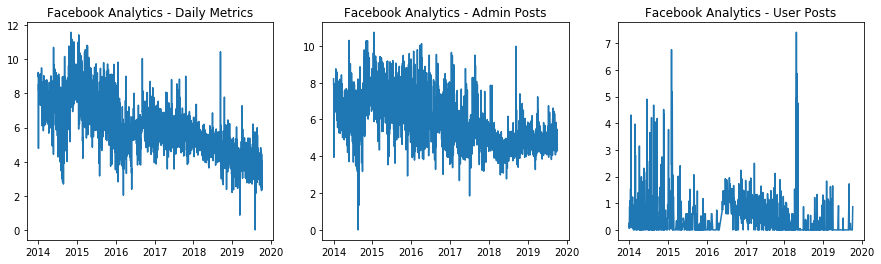

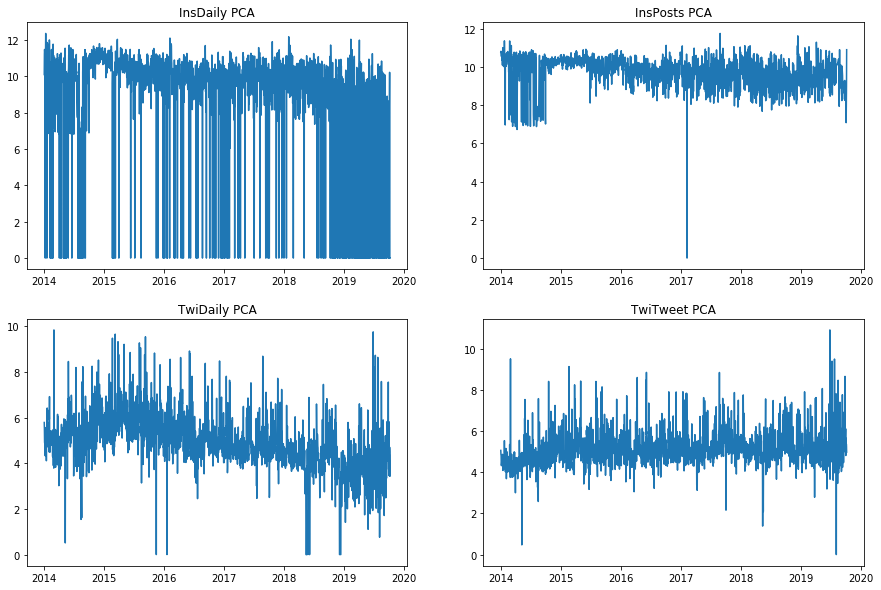

In [73]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(facebook_daily.iloc[:,0])
plt.gca().set_title(facebook_daily.columns[0])
plt.subplot(1,3,2)
plt.plot(facebook_admin.iloc[:,0])
plt.gca().set_title(facebook_admin.columns[0])
plt.subplot(1,3,3)
plt.plot(facebook_user.iloc[:,0])
plt.gca().set_title(facebook_user.columns[0])
plt.show()

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(InsDaily.iloc[:,0])
plt.gca().set_title(InsDaily.columns[0])
plt.subplot(2,2,2)
plt.plot(InsPosts.iloc[:,0])
plt.gca().set_title(InsPosts.columns[0])
plt.subplot(2,2,3)
plt.plot(TwiDaily.iloc[:,0])
plt.gca().set_title(TwiDaily.columns[0])
plt.subplot(2,2,4)
plt.plot(TwiTweet.iloc[:,0])
plt.gca().set_title(TwiTweet.columns[0])
plt.show()

In [74]:
print(np.shape(facebook_daily))
print(np.shape(facebook_admin)) 
print(np.shape(facebook_user)) # remvoe this one 
print(np.shape(InsDaily))
print(np.shape(InsPosts)) # remvoe this one 
print(np.shape(TwiDaily))
print(np.shape(TwiTweet))

(2106, 2)
(2103, 2)
(1351, 2)
(2106, 2)
(1870, 2)
(2106, 2)
(2101, 2)


#### From above two results, remove facebook_user and InsPosts and merge the rest of data

In [75]:
final_df=facebook_daily.join(facebook_admin,how='outer').join(InsDaily,how='outer').join(TwiDaily,how='outer').join(TwiTweet,how='outer')

In [78]:
"""Interpolate Missing Data because of Outer Join"""
def interpolate_dataset(dataset):
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                    if str(dataset.iloc[ii+1,jj])=='nan':
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                    else:
                        dataset.iloc[ii,jj]=(dataset.iloc[ii-1,jj]+dataset.iloc[ii+1,jj])/2
                except:
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
    return dataset
final_df=interpolate_dataset(final_df)

In [79]:
print(len(final_df))
print(len(pd.date_range('2014-01-01', '2019-10-07').tolist()))
# it covers every day available

2106
2106


# Analysis from supplier

In [80]:
def getMostImportantSuppliers(ticker):
    '''
    Input a ticker name, then output the stock price o 3 most important customer in the supply chain.
    '''
    data_1 = quandl.get_table('GSCR/GSPLY',paginate=True,supplier_ticker=ticker)
    
    df_selected=pd.concat([data_1.groupby("customer_name").sum()[["revenue_dependency"]],data_1.groupby("customer_name").count()[["supplier_name"]]],sort=True,axis=1)
    customer_selected=df_selected.sort_values(by=["supplier_name","revenue_dependency"],ascending=False).index[:3].values.tolist()
    customer_selected_ticker=pd.concat([data_1.groupby("customer_ticker").sum()[["revenue_dependency"]],data_1.groupby("customer_ticker").count()[["supplier_ticker"]]],sort=True,axis=1).sort_values(by=["supplier_ticker","revenue_dependency"],ascending=False).index[:3].values.tolist()
    
    data_3 = quandl.get_table('GSCR/GSREF',ticker=customer_selected_ticker,paginate=True)
    data_3=data_3.drop(columns=["publish_date"]).drop_duplicates()
    Final_Result=data_3[data_3['company_name'].isin(customer_selected)]
    comb=[]
    for i in Final_Result.ticker:
        df = quandl.get('EOD/'+i, start_date='2014-01-01', end_date='2019-10-18')
        df = df.loc[:,['Adj_Close']]
        df = df.rename({'Adj_Close':i+' Price'},axis=1)
        comb.append(df)
    comb = pd.concat(comb,axis=1,sort=True)
    return comb

supply_chain_price = getMostImportantSuppliers(ticker)
supply_chain_price.head()

,BBY Price,S Price,VZ Price
Date,,,
2014-01-02,33.810433,10.40,37.359746
2014-01-03,33.960702,9.94,36.917529
2014-01-06,32.900473,9.77,37.123389
2014-01-07,32.040603,9.87,37.588479
2014-01-08,31.589797,9.98,37.382620


Sentiment score is available at weekend but the market price data is not.So i use algorthms to calcualte average sentiment scores for the weekend and append it to monday data

In [81]:
#download stock price timeseries
price = quandl.get('EOD/'+ticker, start_date='2014-01-01', end_date='2019-10-18')
price['date']=price.index
price=price.loc[:,['Adj_Close','Adj_Volume','date']]

#merge everything
df=price.join(final_df,how='outer').join(supply_chain_price,how='outer')

In [82]:
def interpolate_dataset_style2(dataset):
    for ii,i in enumerate(dataset.index):
        for jj,j in enumerate(dataset):
            if str(dataset.iloc[ii,jj])=='nan':
                try:
                        dataset.iloc[ii,jj]=dataset.iloc[ii-1,jj]
                except:
                        dataset.iloc[ii,jj]=dataset.iloc[ii+1,jj]
    return dataset
df=interpolate_dataset_style2(df)
df=df.groupby('date').mean()

In [83]:
df

,Adj_Close,Adj_Volume,Facebook Analytics - Daily Metrics,organic-engagement_score,Facebook Analytics - Admin Posts,facebook admin sentiment,InsDaily PCA,InsDaily engagement_score,TwiDaily PCA,TwiDaily engagement_score,TwiTweet PCA,TwiTweet engagement_score,BBY Price,S Price,VZ Price
date,,,,,,,,,,,,,,,
2014-01-02,71.315909,58671200.0,9.234711,113.333333,7.843942,0.333333,11.235873,498.0,5.510158,156.666667,4.862481,172.555556,33.810433,10.40,37.359746
2014-01-03,69.749391,98116900.0,9.063719,71.500000,7.962887,0.277778,11.476927,496.5,4.916147,128.666667,4.817946,188.166667,33.960702,9.94,36.917529
2014-01-06,70.129739,103152700.0,8.173333,231.400000,7.175932,0.454545,11.163211,496.0,4.858447,69.666667,4.408814,110.285714,32.900473,9.77,37.123389
2014-01-07,69.627873,79302300.0,8.538857,82.000000,7.763083,0.307692,0.000000,0.0,4.324679,144.666667,4.539490,119.500000,32.040603,9.87,37.588479
2014-01-08,70.069141,64632400.0,7.734017,46.800000,6.850540,0.250000,10.516941,488.0,4.834874,87.000000,4.322529,100.000000,31.589797,9.98,37.382620
2014-01-09,69.174227,69787200.0,8.421085,200.166667,6.948507,0.230769,11.634198,481.0,4.957115,135.333333,4.337274,118.600000,31.331002,9.42,36.611844
2014-01-10,68.712781,76244000.0,8.070296,24.000000,6.762485,0.181818,12.360422,495.5,5.309642,102.666667,4.430716,124.363636,31.564753,9.46,36.804538
2014-01-13,69.072500,94623200.0,8.393067,94.333333,7.043202,0.173913,11.263069,490.0,5.014110,134.666667,4.602309,157.571429,30.771668,9.09,36.249579
2014-01-14,70.446910,83140400.0,8.299530,136.166667,7.141435,0.263158,10.324698,499.0,4.108067,124.000000,4.088971,89.600000,30.930285,9.17,36.288118


Choosing the right amount of nodes and layers
There is no final, definite, rule of thumb on how many nodes (or hidden neurons) or how many layers one should choose, and very often a trial and error approach will give you the best results for your individual problem. The most common framework for this is most likely the k-fold cross-validation. However, even for a testing procedure, we need to choose some (k) numbers of nodes.
The following formula may give you a starting point:
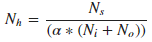

Nᵢ is the number of input neurons, Nₒ the number of output neurons, Nₛ the number of samples in the training data, and α represents a scaling factor that is usually between 2 and 10. We can calculate 8 different numbers to feed into our validation procedure and find the optimal model, based on the resulting validation loss.
If the problem is simple and time an issue, there are various other rules of thumbs to determine the number of nodes, which are mostly simply based on the input and output neurons. We have to keep in mind that, while easy to use, they will rarely yield the optimal result. Here is just one example, which we will use for this basic model:



In [84]:

# univariate multi-step encoder-decoder convlstm
from math import sqrt
from numpy import split
from numpy import array
import numpy as np

from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import BatchNormalization


# train the model





In [85]:
# load the new file
dataset = df


# define the number of subsequences and the length of subsequences
n_steps, n_length = 4, 5
# define the total days to use as input
n_input = n_length * n_steps
n_out=1
delay=5

In [86]:
def split_dataset(dataset,n_input):
    data=dataset.values
    train, test = data[:1200,:], data[1200:1460,:]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/n_input))
    test = array(split(test, len(test)/n_input))
    return train, test

def to_supervised(train, n_input, n_out,delay):
    train = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    train_x, train_y = array(X), array(y)
    # step over the entire history one time step at a time
    for in_start in range(len(train)-n_input-delay):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + delay
        # ensure we have enough data for this instance
        if out_end <= len(train):
            X.append(train[in_start:in_end, :])
            y.append(train[out_end, 0]-train[in_end,0])
    return array(X), array(y)

def forecast(model, data, n_steps, n_length, n_input):
	# flatten data
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, n_features))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat


    

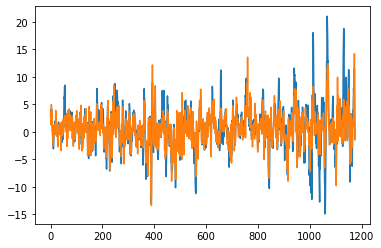

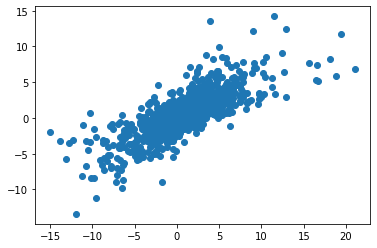

the training error is 1361.3234297526747
the testing error is 1528.3173219185917


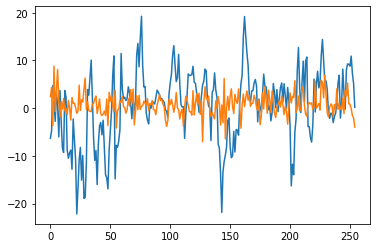

In [87]:
########################################### train the model ########################################### 

train, test = split_dataset(dataset,n_input)
train_x, train_y = to_supervised(train, n_input,n_out,delay)
# prepare data   
verbose, epochs, batch_size = 0, 10, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], 1
# reshape into subsequences [samples, time steps, rows, cols, channels]
train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
train_y = train_y.reshape((train_y.shape[0], 1, 1))
model = Sequential()
model.add(ConvLSTM2D(filters=50, kernel_size=(1,5), kernel_initializer='glorot_uniform', return_sequences=True
                     ,unit_forget_bias=False, activation='tanh', recurrent_activation='hard_sigmoid',
                     go_backwards=True, input_shape=(n_steps, 1, n_length, n_features)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(RepeatVector(n_outputs))
model.add(LSTM(80, activation='tanh', return_sequences=True))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(20, activation='relu')))
model.add(BatchNormalization())
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')# fit network
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)



########################################### Check the consistency ########################################### 
prede=[]
for i in range(len(train_y)):
    a = model.predict(train_x[i:i+1], verbose=0)
    prede.append(a[0,0,0])

plt.plot(train_y[:,0,0])
plt.plot(prede[:])
plt.show()
plt.scatter(train_y[:,0,0],prede[:])
plt.show()

test2 = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))
history = [x for x in train]
history = array(history)
history = history.reshape((history.shape[0]*history.shape[1], history.shape[2]))
predictions=[]
actual=[]
for i in range(len(test2)-delay):
    # predict the week
    yhat = forecast(model, history, n_steps, n_length, n_input)
    # store the predictions
    predictions.append(yhat)
    # get real observation and add to history for predicting the next week
    history = np.append(history,test2[i].reshape(1,-1), axis=0)
    actual.append(test2[i+5,0]-test2[i,0])
    
# evaluate predictions days for each week
predictions = array(predictions)
plt.plot(actual)
plt.plot(predictions[:,0,0])


print('the training error is {}'.format(np.abs(train_y[500:,0,0]-prede[500:]).sum()))
print('the testing error is {}'.format(np.abs(predictions[:,0,0]-actual).sum()))

In [98]:
def decideondate(n):
    data=df.values
    input_x = data[n-20:n,:]
    input_x = input_x.reshape((1, n_steps, 1, n_length, n_features))
    yhat = model.predict(input_x, verbose=0)
    yhat=yhat[0]
    return yhat

In [105]:
yhat=decideondate(30)[0][0]
yhat

-2.6356924

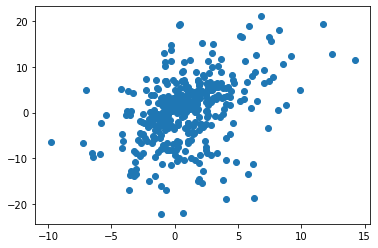

In [212]:
decisionarr=[decideondate(n)[0][0] for n in np.arange(1000,1400)]
actualarr=[df.values[n+5,0]-df.values[n,0] for n in np.arange(1000,1400)]
plt.scatter(decisionarr,actualarr)

0.716863688670363


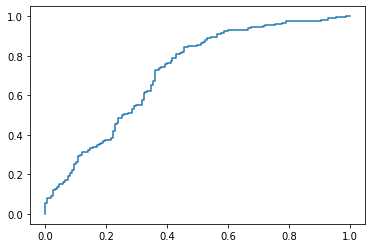

In [213]:
from sklearn import metrics
actualdirection=np.sign(np.array(actualarr)+0.0001)
mindecision=np.min(decisionarr)
maxdecision=np.max(decisionarr)
decisionarrrescaled=(decisionarr-mindecision)/(maxdecision-mindecision)
fpr, tpr, thresholds=metrics.roc_curve(actualdirection, decisionarrrescaled)
plt.plot(fpr,tpr)
print(metrics.roc_auc_score(actualdirection, decisionarrrescaled))

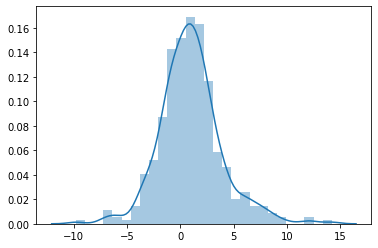

In [219]:
import seaborn as sns
sns.distplot(decisionarr)

In [240]:
thr=1
np.sum(np.array(actualarr)[[np.array(decisionarr)>thr][0]])-np.sum(np.array(actualarr)[[np.array(decisionarr)<-thr][0]])

779.73974757672

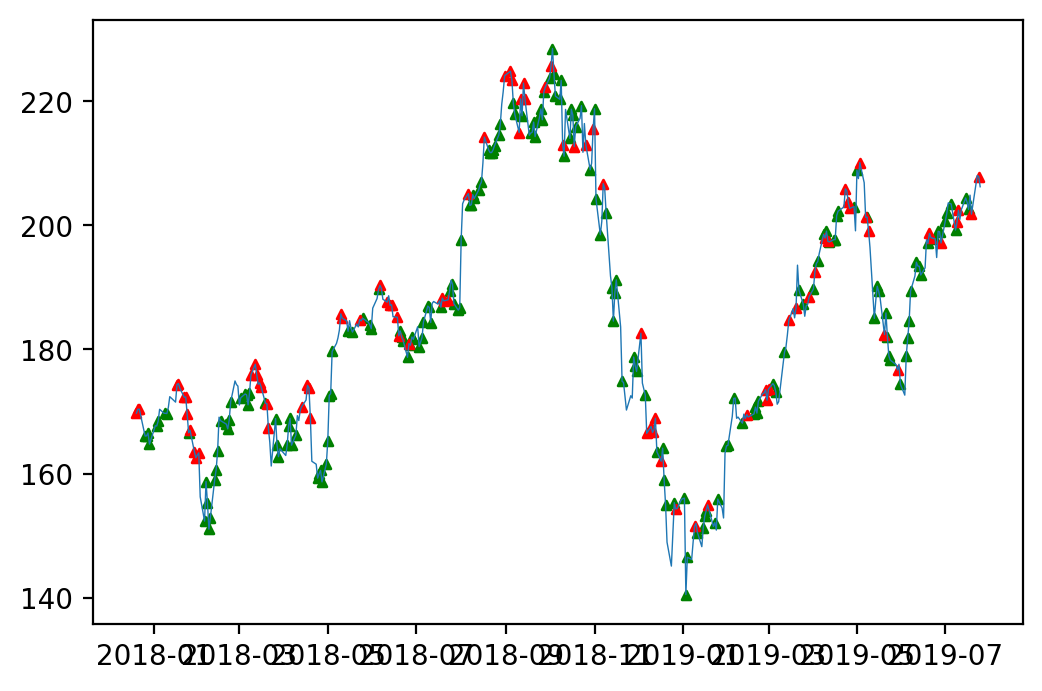

In [302]:
from matplotlib.pyplot import figure
figure(dpi=200)
testdf=df.iloc[1000:1400,0]
plt.plot(testdf,linewidth=0.5)
buytimes=testdf[np.array(decisionarr)>thr]
plt.scatter(buytimes.index,buytimes.tolist(),color='green', s=10, marker="^")
selltimes=testdf[np.array(decisionarr)<-thr]
plt.scatter(selltimes.index,selltimes.tolist(),color='red', s=10, marker="^")

In [287]:
testdf[np.array(decisionarr)>thr]

date
2017-12-26    166.045222
2017-12-27    166.074426
2017-12-28    166.541693
2017-12-29    164.740769
2018-01-03    167.661187
2018-01-04    168.439965
2018-01-09    169.705479
2018-01-10    169.666540
2018-01-25    166.570897
2018-02-05    152.338728
2018-02-06    158.705239
2018-02-07    155.307819
2018-02-08    151.034274
2018-02-09    152.874138
2018-02-12    159.031718
2018-02-13    160.624869
2018-02-14    163.586372
2018-02-16    168.531984
2018-02-20    167.965095
2018-02-21    167.202728
2018-02-22    168.600401
2018-02-23    171.532582
2018-03-02    172.226532
2018-03-05    172.822742
2018-03-06    172.676133
2018-03-07    171.073207
2018-03-08    172.940029
2018-03-19    171.337103
2018-03-26    168.864297
2018-03-27    164.534444
                 ...    
2019-04-17    201.567638
2019-04-18    202.292023
2019-04-29    203.036254
2019-05-01    208.900798
2019-05-08    201.339407
2019-05-13    185.011215
2019-05-15    190.191370
2019-05-16    189.354576
2019-05-21    185.88